In [27]:
%%capture 
# Hide matplotlib backend error

import os
import pandas as pd 
from sklearn import preprocessing
from math import sqrt
from statistics import mean, stdev
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set(font='arial')
_jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

%matplotlib inline

#Set path to this directory for accessing and saving files
__path__  = os.getcwd() + os.path.sep

In [2]:
print(__path__)

C:\Users\jorda\Desktop\bensard_figures_2019-master\


## TCGA Data

In [3]:
# Import TCGA/GTEx Unity Data 

data_dir = os.path.join(__path__, 'data', 'tcga_unity_data') + os.path.sep

file_list = ['colon-rsem-fpkm-gtex.txt',
            'coad-rsem-fpkm-tcga.txt',
            'coad-rsem-fpkm-tcga-t.txt']
file_list = [str(data_dir) + str(x) for x in file_list]

#Initialize
df_list = []
meta = pd.DataFrame(columns = [0,1])
previous = 0
label_number = 0
drop_extra='Entrez_Gene_Id'
label_list = [
    'GTEX_Normal',
    'TCGA_Normal',
    'TCGA_Tumor']

#Import
for x in range(len(file_list)):

    #Get and clean data
    data = pd.read_csv(
        str(file_list[x]),
        index_col = 0,
        sep = '\t')
    data.index.name = None

    #Drop extra column if needed
    if drop_extra != None:
        data = data.drop(labels=['Entrez_Gene_Id'], axis=1)

    #Add data to data list
    df_list.append(data)

    print('Size of ' + str(file_list[x]) + ': ' + str(data.shape))

    #Get metadata for current data matrix
    data_L = data.columns.tolist()

    for x in range(len(data_L)):
        meta.loc[previous + x] = [data_L[x], label_list[label_number]]

    #Update iterators
    previous = previous + len(data_L)
    label_number += 1

#Join dataframes
data = pd.concat(df_list, axis=1)
print('Size of final dataframe: ' + str(data.shape))
print('Size of final metadata table: ' + str(meta.shape))

data_scale = data.copy()
data_scale[data_scale.columns] = preprocessing.scale(data_scale[data_scale.columns], axis=1)

Size of C:\Users\jorda\Desktop\bensard_figures_2019-master\data\tcga_unity_data\colon-rsem-fpkm-gtex.txt: (19096, 339)
Size of C:\Users\jorda\Desktop\bensard_figures_2019-master\data\tcga_unity_data\coad-rsem-fpkm-tcga.txt: (19096, 41)
Size of C:\Users\jorda\Desktop\bensard_figures_2019-master\data\tcga_unity_data\coad-rsem-fpkm-tcga-t.txt: (19096, 285)
Size of final dataframe: (19096, 665)
Size of final metadata table: (665, 2)


In [5]:
sample_colors = {'GTEX_Normal': '#005f42',
                 'TCGA_Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
                 'TCGA_Tumor': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921)
                }

test_genes = [
    'SPTLC1',
    'SPTLC2',
    'CERS6',
    'DEGS1',
    'DEGS2',
    'SGMS1',
    'SGMS2',
    'ME1', 
    'ME2', 
    'PC'
]

control_genes = [
    'CERS1', # doesn't seem to be expressed well in TCGA data
    'CERS2', # doesn't seem to be expressed well in TCGA data
    'CERS3', # doesn't seem to be expressed well in TCGA data
    'CERS4',
    'CERS5',
    'UGCG',
    'SPHK2',
    'SGPL1' # doesn't seem to be expressed well in TCGA data
]

data_scale_genes = data_scale.copy()
data_scale_genes = data_scale_genes.loc[test_genes]

### To remove the constraint on expression magnitude, 
### remove the line below and run the code block
data_scale_genes[data_scale_genes > 5] = 5 # <-- Remove this one

In [7]:
"""Prepare a color map from palette dictionary"""
meta = meta.T
meta.columns = meta.iloc[0]
meta = meta.reindex(meta.index.drop(0))
meta = meta.rename({1: 'samples'})
labels = meta.iloc[0]
_color_map = labels.map(sample_colors)

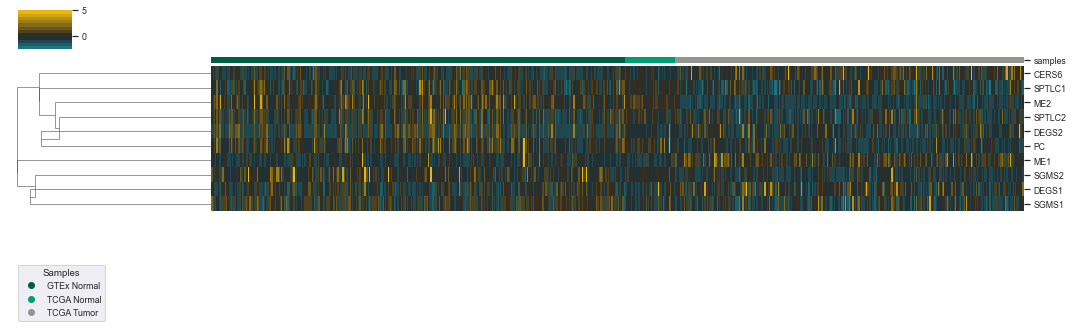

In [9]:
_font_scale = 0.8
_center = 0
_metric = 'euclidean'
_method = 'centroid'
_xticklabels = False
_yticklabels = True
_linewidths = 0
_linecolor = '#DCDCDC'
_col_cluster = False
_row_cluster = True
_figsize = (15,3)
    
sns.set(font_scale = _font_scale)
ax = sns.clustermap(
    data_scale_genes,
    cmap=_jakes_cmap,
    center=_center,
    metric=_metric,
    method=_method,
    xticklabels=_xticklabels,
    yticklabels=_yticklabels,
    linewidths=_linewidths,
    linecolor=_linecolor,
    col_cluster=_col_cluster,
    row_cluster=_row_cluster,
    col_colors=_color_map,
    figsize=_figsize)

colors = {
    'GTEx Normal': '#005f42',
    'TCGA Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
    'TCGA Tumor': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921)
}

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [g("s", list(colors.values())[i]) for i in range(len(list(colors.values())))]
plt.legend(handles_g, list(colors.keys()), bbox_to_anchor=(0, -7), loc=3, borderaxespad=0., title='Samples')

plt.savefig(
    os.path.join(__path__, 'plots', 'tcga_test_genes_heatmap.pdf'),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [36]:
def cohen_d(comp, base):
    return (mean(comp) - mean(base)) / (sqrt((stdev(comp) ** 2 + stdev(base) ** 2) / 2))

In [37]:
data_effect = data.copy()
data_effect = data_effect.loc[test_genes]

normal = []
tumor = []
for i, r in meta.T.iterrows():
    if 'normal' in r[0].lower():
        normal.append(i)
    else:
        tumor.append(i)
    
data_tumor = data_effect[tumor]
data_normal = data_effect[normal]

In [41]:
"""Cohen's d effect size scale:
Very small   0.01
Small        0.20
Medium       0.50
Large        0.80
Very large   1.20
Huge         2.0

Source:
- Cohen, Jacob (1988). Statistical Power Analysis for the Behavioral Sciences. 
    Routledge. ISBN 978-1-134-74270-7.
- Sawilowsky, S (2009). "New effect size rules of thumb". 
    Journal of Modern Applied Statistical Methods. 8 (2): 467–474. 
    doi:10.22237/jmasm/1257035100.
"""

for i, r in data_effect.iterrows():
    gene = i
    comp = data_tumor.loc[gene].values
    base = data_normal.loc[gene].values
    e = cohen_d(comp, base)
    status = ""
    if abs(e) < 0.01:
        status = "Negligible"
    elif abs(e) >= 0.01 and abs(e) < 0.2:
        status = "Very small"
    elif abs(e) >= 0.2 and abs(e) < 0.5:
        status = "Small"
    elif abs(e) >= 0.5 and abs(e) < 0.8:
        status = "Medium"
    elif abs(e) >= 0.8 and abs(e) < 1.2:
        status = "Large"
    elif abs(e) >= 1.2 and abs(e) < 2.0:
        status = "Very large"
    else:
        status = "Huge"
    
    
    print(gene + ":\t" + str(round(e, 2)) + "\t(" + status + ")")

SPTLC1:	-0.36	(Small)
SPTLC2:	-0.26	(Small)
CERS6:	0.56	(Medium)
DEGS1:	0.2	(Very small)
DEGS2:	-0.14	(Very small)
SGMS1:	-0.31	(Small)
SGMS2:	-0.71	(Medium)
ME1:	0.73	(Medium)
ME2:	-1.44	(Very large)
PC:	-0.7	(Medium)


## GEO Microarray data

In [ ]:
import GEOparse